# **1. Visualize EF5 outputs for Ivory Coast Flash Flood Event**



## Install Necessary Libraries
### Use the following command to install the `rasterio` library if not already installed

In [1]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.1 MB/s eta 0:00:00


## Import Required Libraries
### Import essential libraries for working with geospatial data

In [2]:
#import
import xml.etree.ElementTree as ET
import numpy as np
from google.colab import files
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rasterio')
import pandas as pd
import glob
from datetime import timedelta
import time
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, BoundaryNorm

## **2. Upload Required Files**
### Upload GeoTIFF files from your local machine to Google Colab

In [3]:
uploaded = files.upload()

Saving maxunitq.20180618.183000.tif to maxunitq.20180618.183000.tif


To verify uploaded files, use the following:

In [4]:
os.listdir()


['.config', 'maxunitq.20180618.183000.tif', 'sample_data']

For visualize the EF5 outputs in the desing colorscale we need to upload and use the color palette:

In [5]:
uploaded_colorramp = files.upload()

Saving FLASHunitQColormap_Visual.qml to FLASHunitQColormap_Visual.qml


## **3. Define Utility Functions**

This section defines a function called *create_map_from_tif*. This function takes one argument:

**tif_file_path**: This represents the path to the GeoTIFF file that you want to visualize.
The purpose of the function is to open the GeoTIFF, read its data, and then create a visual representation of it as a map.

In [26]:
def parse_qml_colormap(qml_file_path):
    """
    Parses the .qml file to extract colormap information from the specific structure in QGIS QML files.

    Args:
        qml_file_path: The path to the .qml file.

    Returns:
        A list of color tuples (R, G, B).
    """
    try:
        tree = ET.parse(qml_file_path)
        root = tree.getroot()

        colors = []
        # Loop through each <item> inside <colorrampshader>
        for item in root.iter('item'):
            color = item.attrib.get('color')
            if color:
                # Convert the hex color (e.g., "#595a5a") to RGB format
                try:
                    # Remove the '#' and extract the R, G, B components
                    r = int(color[1:3], 16) / 255  # Normalize to [0, 1]
                    g = int(color[3:5], 16) / 255
                    b = int(color[5:7], 16) / 255
                    colors.append((r, g, b))
                except ValueError:
                    print(f"Skipping invalid color: {color}")

        if not colors:
            print("No valid colors found in QML file.")
        return colors

    except Exception as e:
        print(f"Error parsing QML file: {e}")
        return []


### Create Map from GeoTIFF File

def create_map_from_tif(tif_file_path, qml_file_path, zoom):
    """
    Reads a GeoTIFF file and generates a map visualization using a custom colormap.

    Args:
        tif_file_path (str): Path to the GeoTIFF file.
        qml_file_path (str): Path to the QML colormap file.
        zoom (bool): Whether to zoom into a specific region.
    """
    try:
        # Parse the colormap from the QML file
        colormap = parse_qml_colormap(qml_file_path)

        # If no valid colors are found, raise an error
        if not colormap:
            raise ValueError("No valid colormap found in QML file.")

        # Create a custom colormap using matplotlib
        custom_cmap = ListedColormap(colormap)
        levels_map = [0, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 4, 4.5, 5, 6, 7, 8, 10, 13, 15]
        norm = BoundaryNorm(boundaries=levels_map, ncolors=custom_cmap.N, extend='max')

        # Open the GeoTIFF file
        with rasterio.open(tif_file_path) as src:
            band1 = src.read(1)  # Read the first band

            # Replace -9999 with np.nan (for invalid or missing data)
            band1 = np.where(band1 == -9999, np.nan, band1)


            # Create latitude and longitude arrays using the extent and raster size
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

            if zoom:
                limits = [-5, -3, 4.75, 7]
            else:
                limits = extent

            # The point's latitude and longitude
            point_lat = 5.321
            point_lon = -4.018

            # Display the image using imshow
            plt.figure(figsize=(13, 7))
            img = plt.imshow(
                band1,
                cmap=custom_cmap,
                norm=norm,
                extent=extent,  # Match the GeoTIFF's spatial extent
                origin="upper",  # Ensure the image is oriented correctly
            )
            plt.scatter(x=point_lon, y=point_lat, c='b', marker="*", s=20, label='FF event')

            # Set the extent of the plot
            plt.xlim(limits[0], limits[1])
            plt.ylim(limits[2], limits[3])

            plt.title(f"Map from {tif_file_path}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")

            # Add colorbar for contour levels
            cbar = plt.colorbar(img, extend='max')
            cbar.set_label(r"Max Unit Q ($\mathrm{m^3 s^{-1} km^{-2}}$)")
            cbar.set_ticks(levels_map)
            plt.legend()

            plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {tif_file_path}")
    except rasterio.errors.RasterioIOError:
        print(f"Error: Could not read the GeoTIFF file. Check the file format or path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


## **4. Visualize EF5 Outputs**

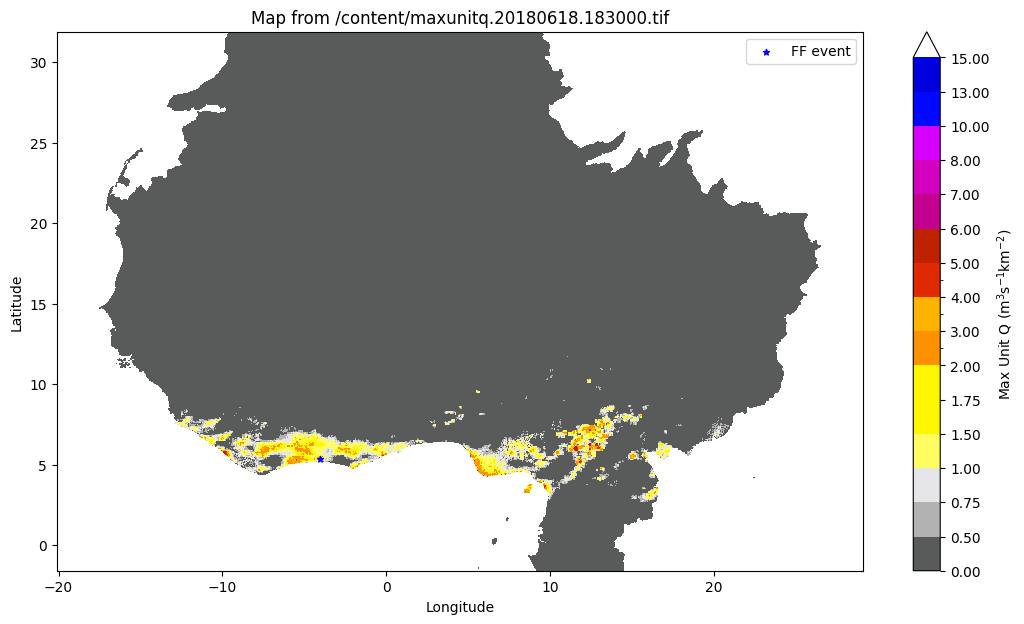

In [8]:
# Define file paths and visualize

tif_file = '/content/maxunitq.20180618.183000.tif'
qml_file_path = '/content/FLASHunitQColormap_Visual.qml'
create_map_from_tif(tif_file, qml_file_path, zoom = False)

Now lets zoom in




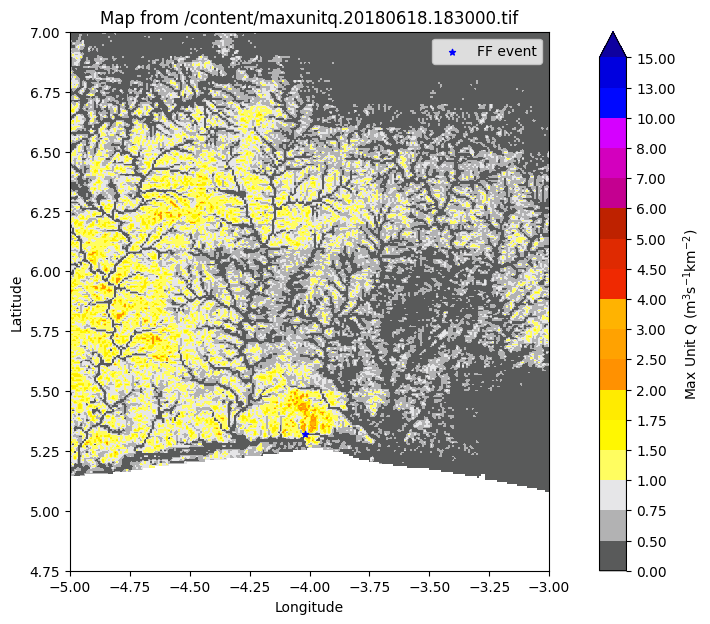

In [28]:
create_map_from_tif(tif_file, qml_file_path,zoom=True)

## **5. Time Series Analysis for EF5 Outputs (90 meters resolution) **

In this section, we will use the 90-meter resolution model that we are calibrating. These results are from the UNCALIBRATED model.

For this exercise, the team has run the model with a 1-year warm-up, and now we are visualizing the results for a specific year.


In [37]:
### Define Error Metrics Calculation
def calculate_error_metrics(df_simulado, df_observado):
    """
    Calculates RMSE, Bias, and NSE between simulated and observed discharge.

    Args:
        df_simulated (DataFrame): Simulated discharge data.
        df_observed (DataFrame): Observed discharge data.

    Returns:
        tuple: RMSE, Bias, and NSE values.
    """

    # Merged the two datasets so the dates coincide
    df_merged = pd.merge(df_simulado, df_observado, how='outer', left_index=True, right_index=True, suffixes=('_simulado', '_observado'))

    # Calculate the error metrics
    df_valid = df_merged.dropna(subset=['Discharge(m^3 s^-1)', 'discharge'])
    from sklearn.metrics import root_mean_squared_error
    rmse = root_mean_squared_error(df_valid['discharge'],df_valid['Discharge(m^3 s^-1)'])
    bias = (df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']).mean()
    nse = 1 - ((df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']) ** 2).sum() / ((df_valid['discharge'] - df_valid['discharge'].mean()) ** 2).sum()

    return rmse, bias, nse

In [36]:
def plotting(Q_daily_df, Q_obs, nse, bias, rmse):
    """
    Plots observed vs. simulated discharge and precipitation.

    Args:
        Q_daily_df (DataFrame): Simulated daily discharge data.
        Q_obs (DataFrame): Observed discharge data.
        nse, bias, rmse: Error metrics.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,10))
    ax1 = plt.subplot(1,1,1)
    ax1.scatter(Q_obs.index, Q_obs['discharge'], color = 'black', label='Observed')
    ax1.plot(Q_daily_df.index, Q_daily_df['Discharge(m^3 s^-1)'], color='blue', label='Simulated', linewidth=2)
    ax1.set_xlabel('Date', fontsize=20)
    ax1.set_ylabel('Discharge (m^3/s)',fontsize=20, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue',labelsize=16)
    ax1.set_xlim(Q_daily_df.index.values[0], Q_daily_df.index.values[-1])
    ax1.xaxis.set_major_locator(AutoDateLocator(minticks=10, maxticks=20))
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x',labelsize=16,rotation=30)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax1.set_ylim(0,Q_daily_df['Discharge(m^3 s^-1)'].max()+200)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.bar(Q_daily_df.index,Q_daily_df['Precip (mm d^-1)'],color='rebeccapurple',alpha=1,width=0.8,align='center')
    ax2.set_ylim(0,Q_daily_df['Precip (mm d^-1)'].max()+200)
    ax2.invert_yaxis()
    ax2.set_ylabel('Precip (mm d^-1)', color='rebeccapurple',fontsize=20)
    ax2.tick_params(axis='y', labelcolor='rebeccapurple',labelsize=16)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # add the metrics
    ax = plt.gca()
    plt.text(0.02, 0.95, f'RMSE: {rmse:.2f}\nBias: {bias:.2f}\nNSE: {nse:.2f}', transform=ax.transAxes, fontsize=16,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    ax1.legend(fontsize=16)
    plt.title('GAUGE= 1006007')

    plt.show()


### Use a calibrated 90m resolution model and visualize time series against observed data.

### Upload time series data

In [31]:
timeseries = files.upload()

Saving 1006007_daily_Q.csv to 1006007_daily_Q.csv
Saving ts.1006007.crest.csv to ts.1006007.crest.csv


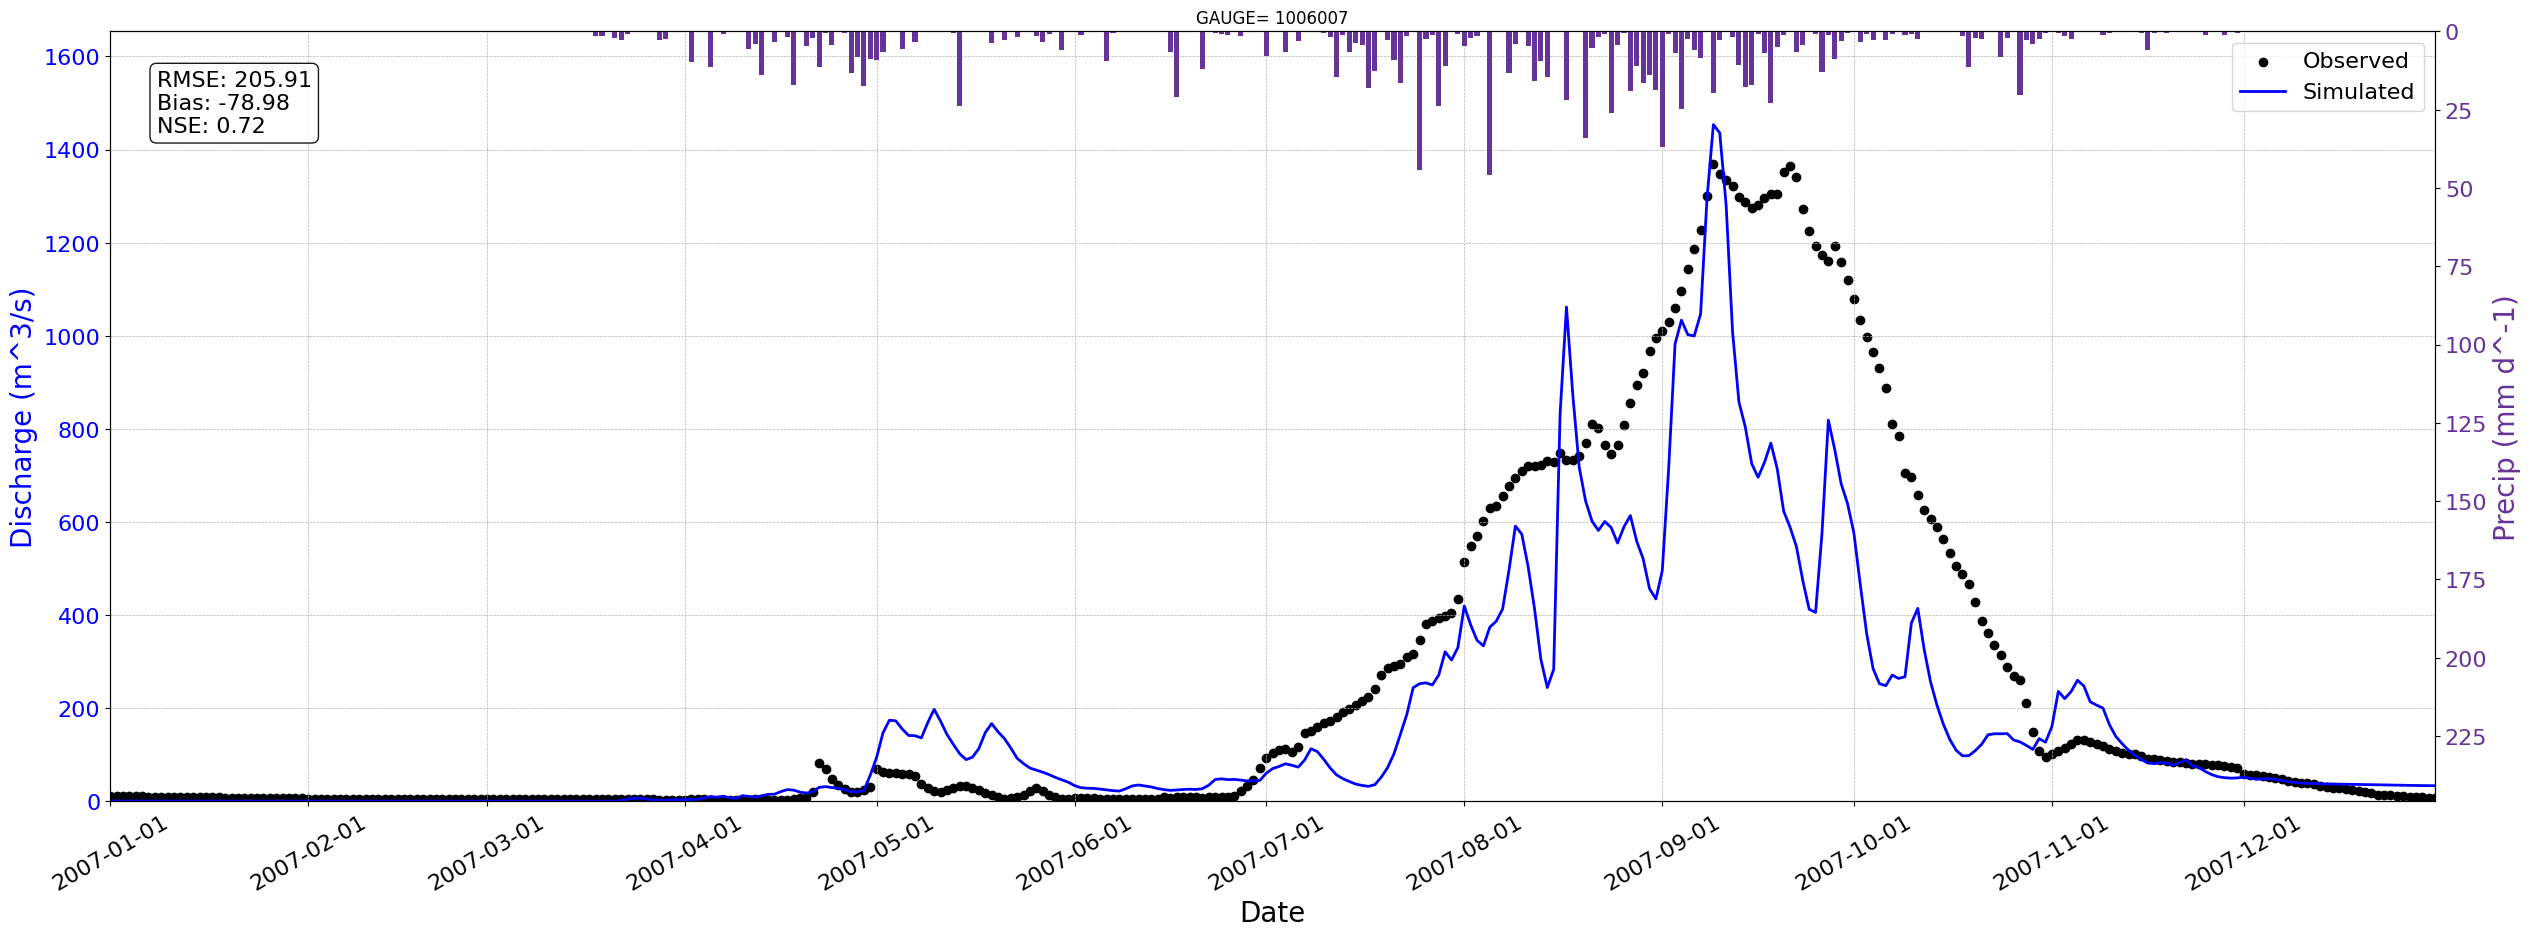

In [38]:
# Read the model results CSV file and convert the 'Time' column to datetime format
ef5_file = pd.read_csv('ts.1006007.crest.csv', sep =',')
ef5_file['Time'] =  pd.to_datetime(ef5_file['Time'])
# Set the 'Time' column as the index for easier time-based indexing
ef5_file = ef5_file.set_index('Time')

# Read the observed data CSV file and convert the 'date' column to datetime format
file_obs = pd.read_csv('1006007_daily_Q.csv', sep =',')
file_obs['date'] =  pd.to_datetime(file_obs['date'])
file_obs = file_obs.set_index('date')

# Filter the observed data for the year 2007
Q_observed_filtered = file_obs[(file_obs.index.year >= 2007) & (file_obs.index.year < 2008)]

# Get the initial and final dates from the filtered observed data
initial_data = Q_observed_filtered.index[0]
final_data = Q_observed_filtered.index[-1]

# Filter the modeled data to match the time range of the observed data
Q_modeled_filtered = ef5_file.loc[(ef5_file.index >= initial_data) & (ef5_file.index <= final_data)]

# Plot the results and show the error metrics (NSE, Bias, RMSE)
rmse, bias, nse = calculate_error_metrics(Q_modeled_filtered['Discharge(m^3 s^-1)'], Q_observed_filtered['discharge'])
plotting(Q_modeled_filtered, Q_observed_filtered, nse, bias, rmse)